In [2]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 180 (delta 78), reused 134 (delta 49), pack-reused 0
Receiving objects: 100% (180/180), 28.64 MiB | 14.11 MiB/s, done.
Resolving deltas: 100% (78/78), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=15097 sha256=9409928efb2294c4266cfd99c0a76c6ec041eaa9238e15189c5300fc3956c20f
  Stored in directory: /tmp/pip-ephem-wheel-cache-if1ddsnm/wheels/55/59/29/0fb1c63565215773

In [3]:
from dul_2021.utils.pr3_utils import *

In [4]:
from typing import Tuple, List, Optional
from tqdm.auto import trange

import numpy as np
import matplotlib.pyplot as plt
import IPython
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as opt
from torch.distributions import MultivariateNormal

import copy

from scipy.stats import norm
from scipy.optimize import bisect
from tqdm import trange, tqdm_notebook

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
!pip install torchdiffeq
from torchdiffeq import odeint_adjoint as odeint
import torchdiffeq

# Question 1: 2D Data


Dataset 1


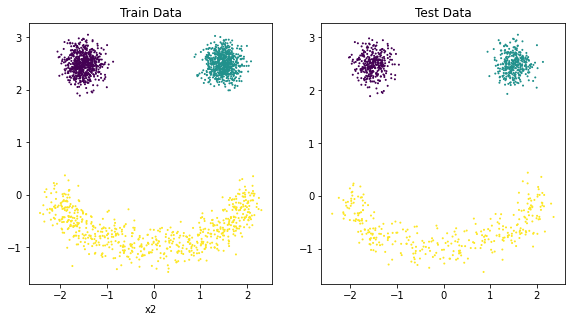

Dataset 2


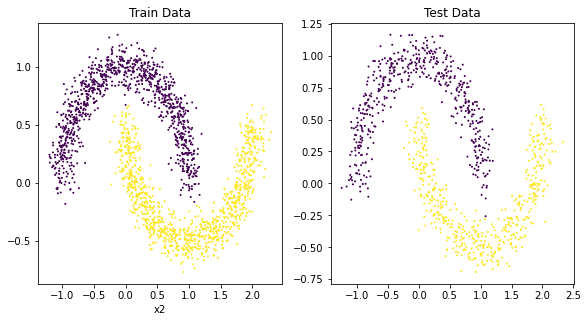

In [7]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Continious Normalazing Flow

Implement continious normalazing flow from [here](https://arxiv.org/pdf/1806.07366.pdf) (botom of page 4). We will be using following transformation parametrization of $\frac{dz(t)}{dt}$:

$\frac{dz(t)}{dt} = u \tanh(\omega^t z(t) + b) \Rightarrow \frac{\partial \log p(z(t))}{\partial z} = - u^t \frac{\partial h}{\partial z}$


Here $\omega, u$ have same dim as $z$ and $b$ is a scalar.

Parametrize $u, \omega, b$ with neural network with single input t. You may find it useful to icrease the 'width' of tansformation by performing m transformation and then averaging them.

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model
* Show a heatmap of the densities learned by your model
* Show what the training set looks like when mapped to the latent space.

## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.



In [8]:
class ContiniousNormalazingFlow(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=16, width=3):
        super().__init__()

        self.input_dim = input_dim
        self.width = width
        self.block_size = width * input_dim

        self.model = self.model = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2 * self.block_size + width)
        )

        self.base_dist = MultivariateNormal(torch.zeros(2, device=device), torch.eye(2, device=device))

    def get_u_w_b(self, t):
        out = self.model(t.unsqueeze(0)).squeeze()

        u = out[: self.block_size].reshape(self.width, 1, self.input_dim)
        w = out[self.block_size : 2 * self.block_size].reshape(self.width, self.input_dim, 1)
        b = out[-self.width :].reshape(self.width, 1, 1)

        return [u, w, b]

    def get_dz_dt(self, t, z):
        u, w, b = self.get_u_w_b(t)
        z_r = z.unsqueeze(0).repeat(self.width, 1, 1)
        h = torch.tanh(z_r.matmul(w) + b)

        return h.matmul(u).mean(dim=0)

    def get_dlog_p_dt(self, f, z):
        batch_size = z.shape[0]
        m_trace = torch.zeros(batch_size, device=device)
        for i in range(self.input_dim):
            m_trace -= torch.autograd.grad(f[:, i].sum(), z, create_graph=True)[0][:, i] #???????

        return m_trace.reshape(batch_size, 1)

    def forward(self, t, input):
        with torch.set_grad_enabled(True):
            z, _ = input
            z.requires_grad_(True)

            dz_dt = self.get_dz_dt(t, z)

            dlog_p_dt = self.get_dlog_p_dt(dz_dt, z)

            return dz_dt, dlog_p_dt

    def flow(self, z_1, t_0=0, t_1=10):
        dlog_p_dt_1 = torch.zeros((z_1.shape[0], 1)).float().to(device)
        z_t, m_log_det_t = odeint(
            self,
            (z_1, dlog_p_dt_1),
            torch.tensor([t_1, t_0]).type(torch.float32).to(device),
            atol=1e-5,
            rtol=1e-5,
            method='dopri5',
        )

        z_0, log_det = z_t[-1], -m_log_det_t[-1]
        
        return z_0, log_det

    def log_prob(self, batch, t_0=0, t_1=10):
        z, log_det = self.flow(batch, t_0, t_1)
        return self.base_dist.log_prob(z).reshape(-1, 1) + log_det

    def calculate_loss(self, batch, t_0=0, t_1=10):
        return -self.log_prob(batch, t_0, t_1).mean()

    @torch.no_grad()
    def test(self, test_dataloader: DataLoader, t_0=0, t_1=10) -> float:
        self.eval()
        sum_loss = 0
        n_elements = 0
        for batch in test_dataloader:
            batch_size = batch.shape[0]
            loss = self.calculate_loss(batch.to(device), t_0, t_1)
            sum_loss += batch_size * loss
            n_elements += batch_size

        return sum_loss.item() / n_elements

    def fit(self,
            train_dataloader: DataLoader,
            test_dataloader: DataLoader,
            t_0=0,
            t_1=10,
            epochs: int = 20,
            lr: float = 1e-3) -> Tuple[List[float], List[float]]:

        train_losses = []
        test_losses = []

        optim = torch.optim.Adam(self.parameters(), lr=lr)

        test_losses.append(self.test(test_dataloader, t_0, t_1))

        for epoch in trange(epochs, desc="Training"):
            self.train()
            sum_loss = 0
            n_elements = 0
            for batch in train_dataloader:
                batch_size = batch.shape[0]

                loss = self.calculate_loss(batch.to(device), t_0, t_1)

                optim.zero_grad()
                loss.backward()
                optim.step()

                sum_loss += batch_size * loss
                n_elements += batch_size

            train_losses.append(sum_loss.item() / n_elements)
            test_losses.append(self.test(test_dataloader, t_0, t_1))
          
        return train_losses, test_losses

    @torch.no_grad()
    def get_probabilities(self, dataloader: DataLoader):
      probabilities = []
      for batch in dataloader:
          batch_probabilities = self.log_prob(batch.to(device)).exp()
          probabilities.append(batch_probabilities.cpu().numpy())
      return np.vstack(probabilities)

    @torch.no_grad()
    def get_latent_vectors(self, dataloader: DataLoader):
        latent_vectors = []
        for batch in dataloader:
            batch_latent_vectors = self.flow(batch.to(device))[0]
            latent_vectors.append(batch_latent_vectors.cpu().numpy())
        return np.vstack(latent_vectors)

In [13]:
def q1(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats in R^2
    test_data: An (n_test, 2) numpy array of floats in R^2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
              used to set different hyperparameters for different datasets, or
              for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
        Refer to the commented hint.
    - a numpy array of size (n_train, 2) of floats in [0,1]^2. This represents 
        mapping the train set data points through our flow to the latent space. 
    """
    
    """ YOUR CODE HERE """

    input_dim = 2
    hidden_dim = 32
    width = 3

    t_0 = 0
    t_1 = 10
    epochs = 100
    batch_size = 128
    lr = 1e-3

    model = ContiniousNormalazingFlow(input_dim, hidden_dim, width).to(device)
    
    train_dataloader = DataLoader(torch.FloatTensor(train_data), batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(torch.FloatTensor(test_data), batch_size=batch_size, shuffle=False)

    train_losses, test_losses = model.fit(train_dataloader, test_dataloader, t_0, t_1, epochs, lr)

    # heatmap
    dx, dy = 0.025, 0.025
    if dset_id == 1:  # face
        x_lim = (-4, 4)
        y_lim = (-4, 4)
    elif dset_id == 2:  # two moons
        x_lim = (-1.5, 2.5)
        y_lim = (-1, 1.5)
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = np.stack([x, y], axis=2).reshape(-1, 2)
    mesh_xs = DataLoader(torch.FloatTensor(mesh_xs),  batch_size=batch_size, shuffle=False)
    densities = model.get_probabilities(mesh_xs)

    points = DataLoader(torch.FloatTensor(train_data), batch_size=batch_size, shuffle=False)
    latents = model.get_latent_vectors(points)

    return train_losses, test_losses, densities, latents

### Results

Once you've implemented `q1`, execute the cells below to visualize and save your results



Training: 100%|██████████| 100/100 [11:36<00:00,  6.96s/it]


Final Test Loss: 1.5539


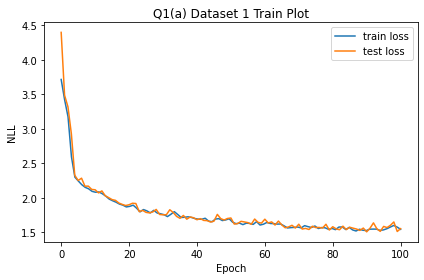

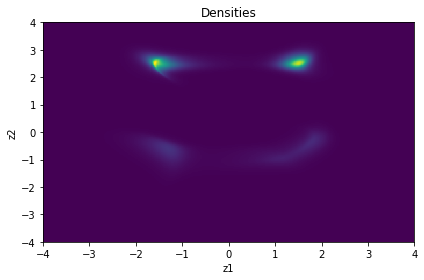

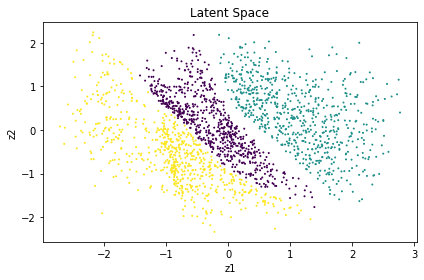

In [14]:
q1_save_results(1, 'a', q1)

Training: 100%|██████████| 100/100 [06:25<00:00,  3.85s/it]


Final Test Loss: 1.2152


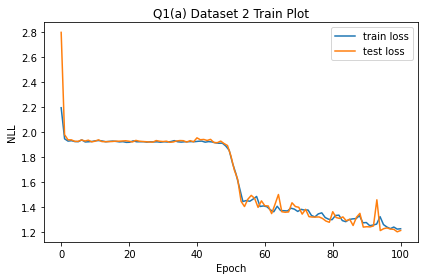

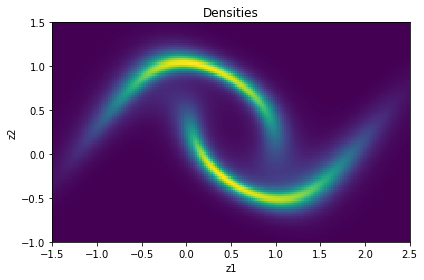

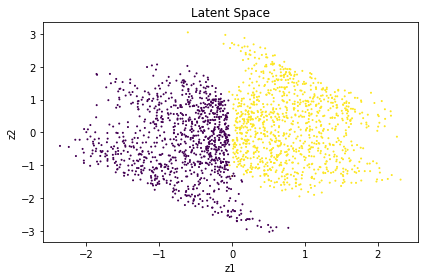

In [17]:
q1_save_results(2, 'a', q1)

# Question 2: Hutchinson's trace estimator

Implement CNF with Hutchinson trace estimator.

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model


## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [11]:
def q2(train_data, test_data):
  """
  train_data: An (n_train, 10) numpy array of floats in R^10
  test_data: An (n_test, 10) numpy array of floats in R^10
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  """
  
  """ YOUR CODE HERE """


### Results

Once you've implemented `q2`, execute the cells below to visualize and save your results



In [12]:
q2_save_results(q2)

NameError: ignored

# Bonus 3: CNF

Implement CNF with Hutchinson trace estimator and bottleneck trick

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model


## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def b3(train_data, test_data):
  """
  train_data: An (n_train, 10) numpy array of floats in R^10
  test_data: An (n_test, 10) numpy array of floats in R^10
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  """
  
  """ YOUR CODE HERE """


### Results

Once you've implemented `b3`, execute the cells below to visualize and save your results



In [ ]:
q2_save_results(b3)